Introduction to Connectivity Matrix

In [16]:
import numpy as np
from NeuroConn.preprocessing.preprocessing import FmriPreppedDataSet
from nilearn import plotting

from sklearn import svm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nilearn
from nilearn.connectome import sym_matrix_to_vec
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score

import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectPercentile

In [ ]:
dataset = FmriPreppedDataSet('/Users/emafikre/Desktop/BIDS')
matrix = dataset.get_conn_matrix(subject='003',task='cs',save=True, save_to='/Users/emafikre/Desktop')

corr_plot = plotting.plot_matrix(matrix[0], figure=(7, 7),vmax=1, vmin=-1, title = 'Connectivity Matrix')

Start of Machine Learning: Data Preperation

In [ ]:
dataset_1 = pd.read_csv('/Users/emafikre/Desktop/vincent/KTT_participants.tsv', sep='\t')
dataset_2 = pd.read_csv('/Users/emafikre/Desktop/vincent/participants_LA5c.tsv', sep='\t')
dataset_3 = pd.read_csv('/Users/emafikre/Desktop/vincent/COBRE_control_participants.tsv', sep='\t')
dataset_4 = pd.read_csv('/Users/emafikre/Desktop/vincent/COBRE_scz_participants.tsv', sep='\t')

dataset_1.rename(columns = {'diag':'diagnosis'}, inplace = True)
dataset_3.rename(columns = {'dx':'diagnosis'}, inplace = True)
dataset_4.rename(columns = {'dx':'diagnosis'}, inplace = True)

dataset_1 = dataset_1[['participant_id','diagnosis']]
dataset_2 = dataset_2[['participant_id','diagnosis']]
dataset_3 = dataset_3[['participant_id','diagnosis']]
dataset_4 = dataset_4[['participant_id','diagnosis']]

dataset_2 = dataset_2[(dataset_2['diagnosis'] == 'SCHZ') | (dataset_2['diagnosis'] == 'CONTROL')]
dataset_3['participant_id'] = 'sub-'+ dataset_3['participant_id']
dataset_4['participant_id'] = 'sub-'+ dataset_4['participant_id']

dataset_1['diagnosis'] = dataset_1['diagnosis'].replace(to_replace= 4, value="1")
dataset_2 = dataset_2.replace(to_replace=["CONTROL"], value="0")
dataset_2 = dataset_2.replace(to_replace=["SCHZ"], value="1")
dataset_3 = dataset_3.replace(to_replace=["No_Known_Disorder"], value="0")
dataset_4 = dataset_4.replace(to_replace=["Schizophrenia_Strict"], value="1")

y = pd.concat([dataset_1,dataset_2,dataset_3,dataset_4], ignore_index=True)
pd.set_option('display.max_rows', 10)
y

In [21]:
def dataprep(schaefer):
    dataset_1 = pd.read_csv('/Users/emafikre/Desktop/vincent/KTT_participants.tsv', sep='\t')
    dataset_2 = pd.read_csv('/Users/emafikre/Desktop/vincent/participants_LA5c.tsv', sep='\t')
    dataset_3 = pd.read_csv('/Users/emafikre/Desktop/vincent/COBRE_control_participants.tsv', sep='\t')
    dataset_4 = pd.read_csv('/Users/emafikre/Desktop/vincent/COBRE_scz_participants.tsv', sep='\t')

    dataset_1.rename(columns = {'diag':'diagnosis'}, inplace = True)
    dataset_3.rename(columns = {'dx':'diagnosis'}, inplace = True)
    dataset_4.rename(columns = {'dx':'diagnosis'}, inplace = True)

    dataset_1 = dataset_1[['participant_id','diagnosis']]
    dataset_2 = dataset_2[['participant_id','diagnosis']]
    dataset_3 = dataset_3[['participant_id','diagnosis']]
    dataset_4 = dataset_4[['participant_id','diagnosis']]

    dataset_2 = dataset_2[(dataset_2['diagnosis'] == 'SCHZ') | (dataset_2['diagnosis'] == 'CONTROL')]
    dataset_3['participant_id'] = 'sub-'+ dataset_3['participant_id']
    dataset_4['participant_id'] = 'sub-'+ dataset_4['participant_id']

    dataset_1['diagnosis'] = dataset_1['diagnosis'].replace(to_replace= 4, value="1")
    dataset_2 = dataset_2.replace(to_replace=["CONTROL"], value="0")
    dataset_2 = dataset_2.replace(to_replace=["SCHZ"], value="1")
    dataset_3 = dataset_3.replace(to_replace=["No_Known_Disorder"], value="0")
    dataset_4 = dataset_4.replace(to_replace=["Schizophrenia_Strict"], value="1")

    y = pd.concat([dataset_1,dataset_2,dataset_3,dataset_4], ignore_index=True)
    pd.set_option('display.max_rows', 10)
    y
    filenames = os.listdir('/Users/emafikre/Desktop/vincent/Features')

    for participant in y['participant_id']:
        if participant not in filenames:
            y.drop(y[y['participant_id'] == participant].index, inplace = True)

    feature_directory= f'/Users/emafikre/Desktop/vincent/Features_{schaefer}/'

    all_features = []
    for participant in y['participant_id']:
        if participant in filenames:
            correlation_matrix = np.load(f"{feature_directory}z-conn-matrix-{participant}-rest-schaefer{schaefer}.npy")
            if len(correlation_matrix.shape) == 3:
                correlation_matrix = correlation_matrix[0, :, :]
            vec_correlation_matrix = nilearn.connectome.sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)
            all_features.append(vec_correlation_matrix)

    np.savez_compressed(f'correlation_matrix{schaefer}.npz',a = all_features)

    x = np.load(f'correlation_matrix{schaefer}.npz')['a']
    y = y['diagnosis']
    y = y.to_numpy()
    diagnosis = pd.DataFrame(y)

    y = y.astype('int')

    return(x, y, diagnosis)

In [2]:
def split(x, y, diagnosis):
    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.25, stratify= diagnosis, random_state=99)

    y_test = y_test.astype('int')
    y_train = y_train.astype('int')

    return(x_train, y_train, x_test, y_test)

In [69]:
def supportvectormachine(schaefer, x_train, y_train, x_test, y_test):
    SVM = svm.SVC(C= 100.0, gamma= 1e-06, kernel= 'sigmoid')

    cross_pred = cross_val_predict(SVM, x_train, y_train, cv=20, n_jobs=-1)
    accuracy = cross_val_score(SVM, x_train, y_train, cv=20, n_jobs=-1)

    for i in range(20):
        print('Fold {} -- Acc = {}'.format(i, accuracy[i]))

    mean = np.mean(accuracy)
    print(mean)
    
    SVM.fit(x_train, y_train)
    y_pred = SVM.predict(x_test)
    print(classification_report(y_test, y_pred))

    return(SVM)

In [70]:
def logisticregresion(schaefer, x_train, y_train, x_test, y_test):
    logit = LogisticRegression(multi_class='auto', solver='liblinear')

    cross_pred = cross_val_predict(logit, x_train, y_train, cv=20, n_jobs=-1)
    acc = cross_val_score(logit, x_train, y_train, cv=20, n_jobs=-1)

    for i in range(20):
        print('Fold {} -- Acc = {}'.format(i, acc[i]))

    mean = np.mean(acc)
    print(mean)

    logit.fit(x_train, y_train)
    y_pred = logit.predict(x_test)
    print(classification_report(y_test, y_pred))

    return(logit)


In [5]:
def roc_graph(x_train, y_train, x_test, y_test):
    SVM = svm.SVC(C= 100.0, gamma= 1e-06, kernel= 'sigmoid', probability=True)
    SVM.fit(x_train, y_train)

    logit = LogisticRegression(multi_class='auto', solver='liblinear')
    logit.fit(x_train, y_train)

    y_pred_proba_svm = SVM.predict_proba(x_test)[::,1]
    fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  y_pred_proba_svm)
    auc_svm = metrics.roc_auc_score(y_test, y_pred_proba_svm)
    auc_svm = round(auc_svm, 2)

    y_pred_proba_log = logit.predict_proba(x_test)[::,1]
    fpr_log, tpr_log, _ = metrics.roc_curve(y_test,  y_pred_proba_log)
    auc_log = metrics.roc_auc_score(y_test, y_pred_proba_log)
    auc_log = round(auc_log, 2)

    plt.plot(fpr_log,tpr_log, label="Logit AUC="+str(auc_log))
    plt.plot(fpr_svm,tpr_svm, label="SVM AUC="+str(auc_svm))
    plt.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

1000-Schaefer First SVM (No Hyperparameters)

In [8]:
x, y, diagnosis = dataprep('1000')

In [9]:
x_train, y_train, x_test, y_test = split(x, y, diagnosis)

In [7]:
SVM = svm.SVC()
SVM.fit(x_train,y_train)

y_pred = SVM.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84        68
           1       0.95      0.42      0.58        43

    accuracy                           0.77       111
   macro avg       0.84      0.70      0.71       111
weighted avg       0.81      0.77      0.74       111



In [8]:
SVM = svm.SVC()

cross_pred = cross_val_predict(SVM, x_train, y_train, cv=20, verbose=3, n_jobs=-1)
accuracy = cross_val_score(SVM, x_train, y_train, cv=20, verbose=3, n_jobs=-1)

for i in range(20):
    print('Fold {} -- Acc = {}'.format(i, accuracy[i]))

np.mean(accuracy)
print(accuracy)
SVM.fit(x_train, y_train)
y_pred = SVM.predict(x_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.3min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.1min remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] END ................................ score: (test=0.765) total time= 1.3min
[CV] END ................................ score: (test=0.471) total time= 1.3min
[CV] END ................................ score: (test=0.706) total time= 1.3min
[CV] END ................................ score: (test=0.647) total time= 1.3min
[CV] END ................................ score: (test=0.824) total time= 1.3min
[CV] END ................................ score: (test=0.588) total time= 1.3min
[CV] END ................................ score: (test=0.706) total time= 1.3min


[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.3min remaining:  5.1min


[CV] END ................................ score: (test=0.706) total time= 1.3min
[CV] END ................................ score: (test=0.688) total time= 1.3min
[CV] END ................................ score: (test=0.765) total time= 1.3min
[CV] END ................................ score: (test=0.706) total time= 1.3min


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min


[CV] END ................................ score: (test=0.706) total time= 1.3min
[CV] END ................................ score: (test=0.750) total time=  48.0s
[CV] END ................................ score: (test=0.688) total time=  48.3s
[CV] END ................................ score: (test=0.625) total time=  47.8s
[CV] END ................................ score: (test=0.750) total time=  47.7s
[CV] END ................................ score: (test=0.750) total time=  47.7s
[CV] END ................................ score: (test=0.812) total time=  47.8s


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.1min remaining:   13.9s


[CV] END ................................ score: (test=0.688) total time=  47.9s
[CV] END ................................ score: (test=0.625) total time=  47.8s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


Fold 0 -- Acc = 0.7058823529411765
Fold 1 -- Acc = 0.8235294117647058
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.7647058823529411
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.7058823529411765
Fold 6 -- Acc = 0.47058823529411764
Fold 7 -- Acc = 0.7058823529411765
Fold 8 -- Acc = 0.7058823529411765
Fold 9 -- Acc = 0.7058823529411765
Fold 10 -- Acc = 0.6470588235294118
Fold 11 -- Acc = 0.6875
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.75
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.6875
Fold 17 -- Acc = 0.8125
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.625
[0.70588235 0.82352941 0.76470588 0.76470588 0.58823529 0.70588235
 0.47058824 0.70588235 0.70588235 0.70588235 0.64705882 0.6875
 0.6875     0.75       0.625      0.75       0.6875     0.8125
 0.75       0.625     ]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84        68
           1       0.95      0.42      0.58        43

    accuracy            

1000-Schaefer SVM w/ Hyperparameters

In [9]:
supportvectormachine(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.7647058823529411
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.7647058823529411
Fold 4 -- Acc = 0.8823529411764706
Fold 5 -- Acc = 0.6470588235294118
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.6470588235294118
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.8125
Fold 13 -- Acc = 0.8125
Fold 14 -- Acc = 0.75
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.875
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.5625
Fold 19 -- Acc = 0.8125
0.7680147058823529
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        68
           1       0.86      0.70      0.77        43

    accuracy                           0.84       111
   macro avg       0.84      0.81      0.82       111
weighted avg       0.84      0.84      0.83       111



Hyper Paramaterization Project: Running Grid Search

In [ ]:
param_grid = {'C': [1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6],  
              'gamma': [1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6],
              'kernel': ['linear','poly', 'rbf', 'sigmoid']}  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1, cv=20)

grid.fit(x_train, y_train) 

print(grid.best_params_) 
grid_predictions = grid.predict(x_test) 
print(classification_report(y_test, grid_predictions)) 

hyper_array = []

for params, mean_scores in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    hyper_array.append([params, mean_scores])

hyper_array = np.array(hyper_array)

print(hyper_array)

np.savez('hyper_array', hyper_array)

In [ ]:
hyper_npz = np.load('/Users/emafikre/Desktop/hyper_array.npz', allow_pickle=True)

array_names = hyper_npz.files
first_array = hyper_npz[array_names[0]]

df = pd.DataFrame(first_array)

df[['C', 'gamma', 'kernel']] = pd.DataFrame(df[0].tolist())

df.rename(columns={1: 'acc'}, inplace=True)
df.drop(0, axis=1, inplace=True)

print(df)

1000-Schaefer LR

In [10]:
logisticregresion(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.7058823529411765
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7058823529411765
Fold 3 -- Acc = 0.7058823529411765
Fold 4 -- Acc = 0.8823529411764706
Fold 5 -- Acc = 0.8235294117647058
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.6470588235294118
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.8125
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.875
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.8125
0.7586397058823529
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        68
           1       0.85      0.65      0.74        43

    accuracy                           0.82       111
   macro avg       0.83      0.79      0.80       111
weighted avg       0.82      0.82      0.81       111



Logistical Regression ROC Graph v. Support Vector Machine ROC Graph

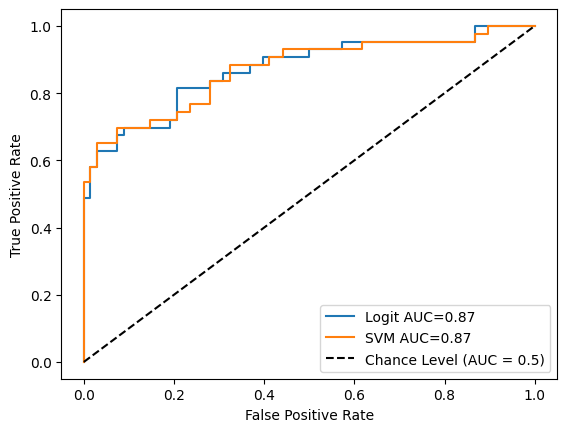

In [11]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Permutation testing

In [ ]:
SVM = svm.SVC(C= 100.0, gamma= 1e-06, kernel= 'sigmoid')

In [ ]:
score, permutation_scores, p_value = sklearn.model_selection.permutation_test_score(SVM, x_test, y_test, n_permutations=10000, random_state=99, verbose=2, n_jobs=-1, scoring='f1')

In [ ]:
data = {'permutation_score': permutation_scores, 'f1 score': [score] * len(permutation_scores), 'p_value': [p_value] * len(permutation_scores)}
df_permutations = pd.DataFrame(data)

df_permutations.to_csv('permutations.csv', index=True)

In [ ]:
fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {p_value:.3f})"
ax.text(0.35, 3, score_label, fontsize=12)
ax.set_xlabel("f1 score")
_ = ax.set_ylabel("Probability")

400-Schaefer

In [12]:
x, y, diagnosis = dataprep('400')
x_train, y_train, x_test, y_test = split(x, y, diagnosis)

In [13]:
supportvectormachine(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.7058823529411765
Fold 1 -- Acc = 0.8235294117647058
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.7058823529411765
Fold 4 -- Acc = 0.6470588235294118
Fold 5 -- Acc = 0.7647058823529411
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.8235294117647058
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.75
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.75
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.6875
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.6875
Fold 19 -- Acc = 0.6875
0.7369485294117648
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        68
           1       0.92      0.53      0.68        43

    accuracy                           0.80       111
   macro avg       0.84      0.75      0.77       111
weighted avg       0.83      0.80      0.79       111



In [14]:
logisticregresion(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.7058823529411765
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.8235294117647058
Fold 3 -- Acc = 0.8235294117647058
Fold 4 -- Acc = 0.7647058823529411
Fold 5 -- Acc = 0.8235294117647058
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.6470588235294118
Fold 9 -- Acc = 0.8235294117647058
Fold 10 -- Acc = 0.7647058823529411
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.875
Fold 14 -- Acc = 0.5625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 0.875
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.75
0.7549632352941177
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        68
           1       0.78      0.65      0.71        43

    accuracy                           0.79       111
   macro avg       0.79      0.77      0.77       111
weighted avg       0.79      0.79      0.79       111



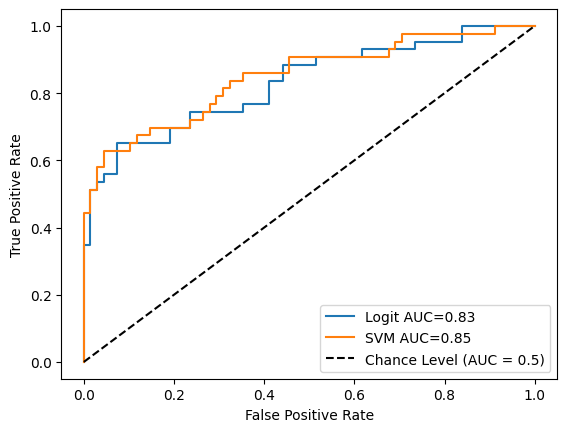

In [15]:
roc_graph(x_train, y_train, x_test, y_test)

200-Schaefer

In [16]:
x, y, diagnosis = dataprep('200')
x_train, y_train, x_test, y_test = split(x, y, diagnosis)

In [17]:
supportvectormachine(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.6470588235294118
Fold 1 -- Acc = 0.6470588235294118
Fold 2 -- Acc = 0.6470588235294118
Fold 3 -- Acc = 0.6470588235294118
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.5882352941176471
Fold 8 -- Acc = 0.5882352941176471
Fold 9 -- Acc = 0.5882352941176471
Fold 10 -- Acc = 0.5882352941176471
Fold 11 -- Acc = 0.625
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.625
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.625
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.625
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.625
0.6165441176470589
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        68
           1       0.00      0.00      0.00        43

    accuracy                           0.61       111
   macro avg       0.31      0.50      0.38       111
weighted avg       0.38      0.61      0.47       111



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [18]:
logisticregresion(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.8235294117647058
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.7058823529411765
Fold 4 -- Acc = 0.9411764705882353
Fold 5 -- Acc = 0.7058823529411765
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7058823529411765
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.5625
Fold 13 -- Acc = 0.8125
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.9375
Fold 17 -- Acc = 1.0
Fold 18 -- Acc = 0.6875
Fold 19 -- Acc = 0.8125
0.7705882352941177
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        68
           1       0.76      0.67      0.72        43

    accuracy                           0.79       111
   macro avg       0.79      0.77      0.78       111
weighted avg       0.79      0.79      0.79       111



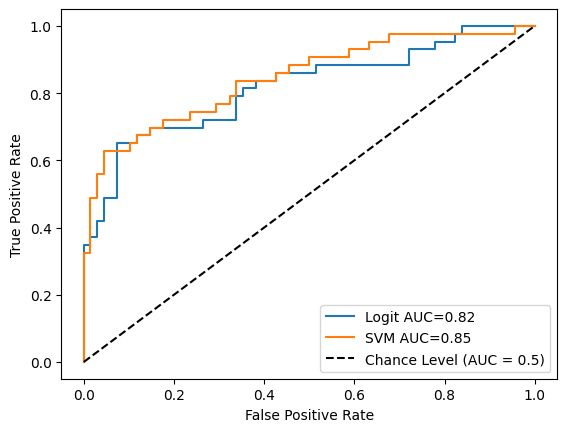

In [19]:
roc_graph(x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

10% Threshold Coding - 1000

In [27]:
x, y, diagnosis = dataprep('1000')
x_new = SelectPercentile(percentile=10).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [40]:
supportvectormachine(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.9411764705882353
Fold 1 -- Acc = 0.9411764705882353
Fold 2 -- Acc = 0.7058823529411765
Fold 3 -- Acc = 0.8235294117647058
Fold 4 -- Acc = 0.7058823529411765
Fold 5 -- Acc = 0.8235294117647058
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.9411764705882353
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.9375
Fold 12 -- Acc = 0.8125
Fold 13 -- Acc = 0.9375
Fold 14 -- Acc = 0.8125
Fold 15 -- Acc = 0.8125
Fold 16 -- Acc = 0.6875
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.8125
Fold 19 -- Acc = 0.6875
0.8130514705882353
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        68
           1       0.94      0.72      0.82        43

    accuracy                           0.87       111
   macro avg       0.89      0.85      0.86       111
weighted avg       0.88      0.87      0.87       111



In [41]:
logisticregresion(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.9411764705882353
Fold 1 -- Acc = 0.8823529411764706
Fold 2 -- Acc = 0.8823529411764706
Fold 3 -- Acc = 0.8823529411764706
Fold 4 -- Acc = 0.9411764705882353
Fold 5 -- Acc = 0.9411764705882353
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.8235294117647058
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.75
Fold 12 -- Acc = 0.75
Fold 13 -- Acc = 0.875
Fold 14 -- Acc = 0.9375
Fold 15 -- Acc = 0.8125
Fold 16 -- Acc = 0.875
Fold 17 -- Acc = 1.0
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.8125
0.8428308823529413
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        68
           1       0.89      0.72      0.79        43

    accuracy                           0.86       111
   macro avg       0.86      0.83      0.84       111
weighted avg       0.86      0.86      0.85       111



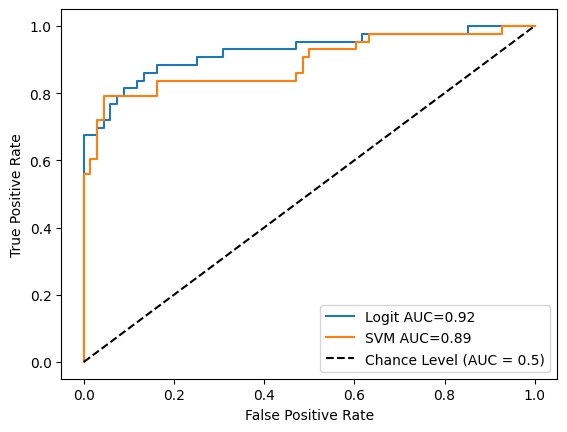

In [42]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

10% Threshold Coding - 400

In [43]:
x, y, diagnosis = dataprep('400')
x_new = SelectPercentile(percentile=10).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [46]:
supportvectormachine(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.6470588235294118
Fold 1 -- Acc = 0.6470588235294118
Fold 2 -- Acc = 0.6470588235294118
Fold 3 -- Acc = 0.6470588235294118
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.5882352941176471
Fold 8 -- Acc = 0.5882352941176471
Fold 9 -- Acc = 0.5882352941176471
Fold 10 -- Acc = 0.5882352941176471
Fold 11 -- Acc = 0.625
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.625
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.625
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.625
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.625
0.6165441176470589
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        68
           1       1.00      0.05      0.09        43

    accuracy                           0.63       111
   macro avg       0.81      0.52      0.43       111
weighted avg       0.77      0.63      0.51       111



In [47]:
logisticregresion(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.7647058823529411
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7058823529411765
Fold 3 -- Acc = 0.7647058823529411
Fold 4 -- Acc = 0.8235294117647058
Fold 5 -- Acc = 0.7647058823529411
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.8235294117647058
Fold 8 -- Acc = 0.7058823529411765
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.75
Fold 13 -- Acc = 0.875
Fold 14 -- Acc = 0.75
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.75
Fold 17 -- Acc = 0.875
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.75
0.7707720588235294
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        68
           1       0.77      0.63      0.69        43

    accuracy                           0.78       111
   macro avg       0.78      0.76      0.76       111
weighted avg       0.78      0.78      0.78       111



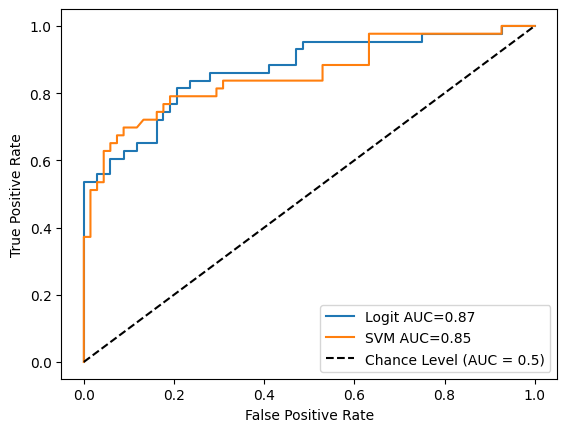

In [48]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

10% Threshold Coding - 200

In [49]:
x, y, diagnosis = dataprep('200')
x_new = SelectPercentile(percentile=10).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [52]:
supportvectormachine(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.6470588235294118
Fold 1 -- Acc = 0.6470588235294118
Fold 2 -- Acc = 0.6470588235294118
Fold 3 -- Acc = 0.6470588235294118
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.5882352941176471
Fold 8 -- Acc = 0.5882352941176471
Fold 9 -- Acc = 0.5882352941176471
Fold 10 -- Acc = 0.5882352941176471
Fold 11 -- Acc = 0.625
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.625
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.625
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.625
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.625
0.6165441176470589
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        68
           1       0.00      0.00      0.00        43

    accuracy                           0.61       111
   macro avg       0.31      0.50      0.38       111
weighted avg       0.38      0.61      0.47       111



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [53]:
logisticregresion(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.8235294117647058
Fold 1 -- Acc = 0.7058823529411765
Fold 2 -- Acc = 0.7058823529411765
Fold 3 -- Acc = 0.7058823529411765
Fold 4 -- Acc = 0.8235294117647058
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.6875
Fold 12 -- Acc = 0.75
Fold 13 -- Acc = 0.875
Fold 14 -- Acc = 0.75
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 1.0
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.6875
0.7560661764705883
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        68
           1       0.77      0.70      0.73        43

    accuracy                           0.80       111
   macro avg       0.79      0.78      0.79       111
weighted avg       0.80      0.80      0.80       111



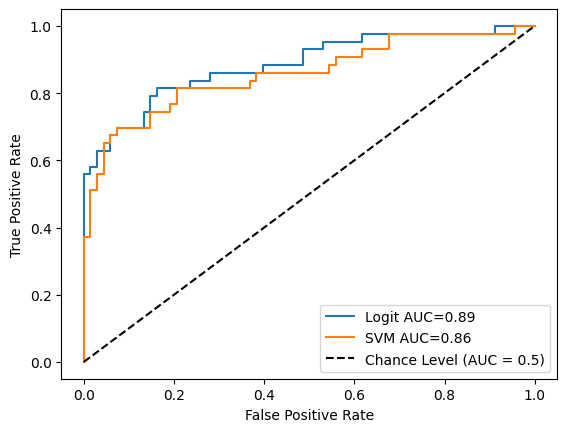

In [54]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

5% Threshold - 1000

In [56]:
x, y, diagnosis = dataprep('1000')
x_new = SelectPercentile(percentile=5).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [57]:
supportvectormachine(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.9411764705882353
Fold 1 -- Acc = 0.8823529411764706
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.7647058823529411
Fold 4 -- Acc = 0.7647058823529411
Fold 5 -- Acc = 0.7647058823529411
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.8235294117647058
Fold 8 -- Acc = 0.8235294117647058
Fold 9 -- Acc = 0.9411764705882353
Fold 10 -- Acc = 0.7647058823529411
Fold 11 -- Acc = 0.875
Fold 12 -- Acc = 0.8125
Fold 13 -- Acc = 0.9375
Fold 14 -- Acc = 0.75
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.875
Fold 18 -- Acc = 0.6875
Fold 19 -- Acc = 0.6875
0.7911764705882354
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        68
           1       0.84      0.63      0.72        43

    accuracy                           0.81       111
   macro avg       0.82      0.78      0.79       111
weighted avg       0.82      0.81      0.80       111



In [58]:
logisticregresion(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.9411764705882353
Fold 1 -- Acc = 0.8823529411764706
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.8823529411764706
Fold 4 -- Acc = 0.8823529411764706
Fold 5 -- Acc = 0.8823529411764706
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.8235294117647058
Fold 10 -- Acc = 0.6470588235294118
Fold 11 -- Acc = 0.75
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.9375
Fold 14 -- Acc = 0.9375
Fold 15 -- Acc = 0.8125
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.75
0.8158088235294118
              precision    recall  f1-score   support

           0       0.85      0.94      0.90        68
           1       0.89      0.74      0.81        43

    accuracy                           0.86       111
   macro avg       0.87      0.84      0.85       111
weighted avg       0.87      0.86      0.86       111



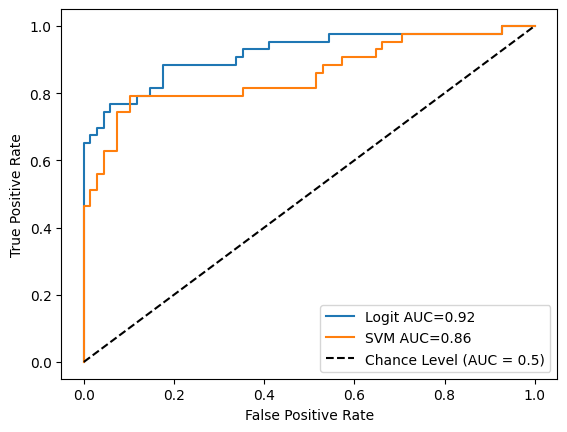

In [59]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

5% Threshold - 400

In [60]:
x, y, diagnosis = dataprep('400')
x_new = SelectPercentile(percentile=5).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [61]:
supportvectormachine(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fold 0 -- Acc = 0.6470588235294118
Fold 1 -- Acc = 0.6470588235294118
Fold 2 -- Acc = 0.6470588235294118
Fold 3 -- Acc = 0.6470588235294118
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.5882352941176471
Fold 8 -- Acc = 0.5882352941176471
Fold 9 -- Acc = 0.5882352941176471
Fold 10 -- Acc = 0.5882352941176471
Fold 11 -- Acc = 0.625
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.625
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.625
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.625
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.625
0.6165441176470589
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        68
           1       0.00      0.00      0.00        43

    accuracy                           0.61       111
   macro avg       0.31      0.50      0.38       111
weighted avg       0.38      0.61      0.47       111



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [62]:
logisticregresion(schaefer='400', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.7647058823529411
Fold 1 -- Acc = 0.8823529411764706
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.8235294117647058
Fold 4 -- Acc = 0.7647058823529411
Fold 5 -- Acc = 0.7058823529411765
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7058823529411765
Fold 8 -- Acc = 0.7058823529411765
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.6875
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.9375
Fold 14 -- Acc = 0.6875
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.75
0.7676470588235295
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        68
           1       0.79      0.70      0.74        43

    accuracy                           0.81       111
   macro avg       0.81      0.79      0.80       111
weighted avg       0.81      0.81      0.81       111



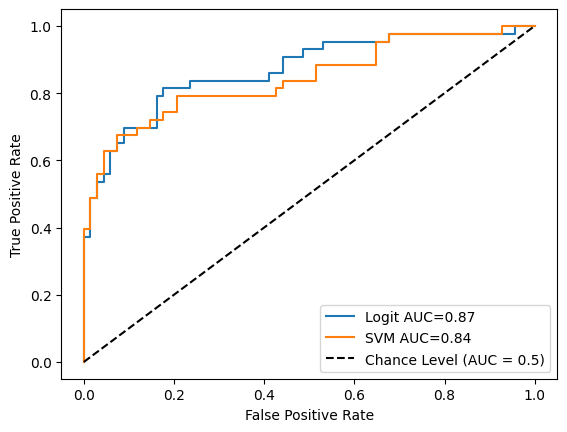

In [63]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

5% Threshold - 200

In [64]:
x, y, diagnosis = dataprep('200')
x_new = SelectPercentile(percentile=5).fit_transform(x,y)
x_train, y_train, x_test, y_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [65]:
supportvectormachine(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.6470588235294118
Fold 1 -- Acc = 0.6470588235294118
Fold 2 -- Acc = 0.6470588235294118
Fold 3 -- Acc = 0.6470588235294118
Fold 4 -- Acc = 0.5882352941176471
Fold 5 -- Acc = 0.5882352941176471
Fold 6 -- Acc = 0.5882352941176471
Fold 7 -- Acc = 0.5882352941176471
Fold 8 -- Acc = 0.5882352941176471
Fold 9 -- Acc = 0.5882352941176471
Fold 10 -- Acc = 0.5882352941176471
Fold 11 -- Acc = 0.625
Fold 12 -- Acc = 0.625
Fold 13 -- Acc = 0.625
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.625
Fold 16 -- Acc = 0.625
Fold 17 -- Acc = 0.625
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.625
0.6165441176470589
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        68
           1       0.00      0.00      0.00        43

    accuracy                           0.61       111
   macro avg       0.31      0.50      0.38       111
weighted avg       0.38      0.61      0.47       111



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [66]:
logisticregresion(schaefer='200', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.8235294117647058
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.5882352941176471
Fold 4 -- Acc = 0.7647058823529411
Fold 5 -- Acc = 0.47058823529411764
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.8235294117647058
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.75
Fold 12 -- Acc = 0.8125
Fold 13 -- Acc = 0.8125
Fold 14 -- Acc = 0.5
Fold 15 -- Acc = 0.8125
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 0.875
Fold 18 -- Acc = 0.8125
Fold 19 -- Acc = 0.6875
0.7408088235294118
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        68
           1       0.74      0.67      0.71        43

    accuracy                           0.78       111
   macro avg       0.77      0.76      0.77       111
weighted avg       0.78      0.78      0.78       111



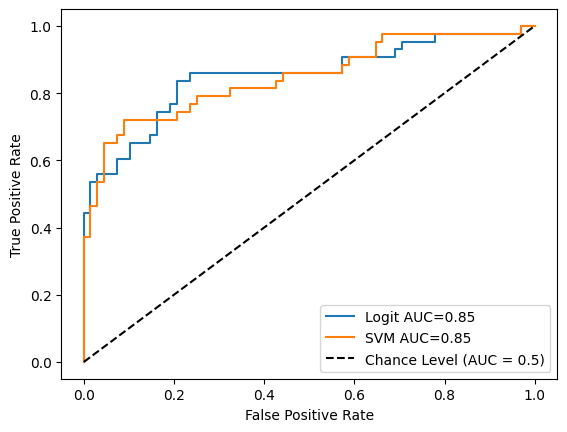

In [67]:
roc_graph(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

10% 1000-LR Confusion Matrix

In [75]:
x, y, diagnosis = dataprep('1000')
x_new = SelectPercentile(percentile=5).fit_transform(x,y)
xt_train, yt_train, xt_test, yt_test = split(x=x_new , y=y, diagnosis=diagnosis)

In [76]:
logit_threshold = logisticregresion(schaefer='1000', x_train=xt_train, y_train=yt_train, x_test=xt_test, y_test=yt_test)

Fold 0 -- Acc = 0.9411764705882353
Fold 1 -- Acc = 0.8823529411764706
Fold 2 -- Acc = 0.7647058823529411
Fold 3 -- Acc = 0.8823529411764706
Fold 4 -- Acc = 0.8823529411764706
Fold 5 -- Acc = 0.8823529411764706
Fold 6 -- Acc = 0.7058823529411765
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.7647058823529411
Fold 9 -- Acc = 0.8235294117647058
Fold 10 -- Acc = 0.6470588235294118
Fold 11 -- Acc = 0.75
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.9375
Fold 14 -- Acc = 0.9375
Fold 15 -- Acc = 0.8125
Fold 16 -- Acc = 0.8125
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.75
Fold 19 -- Acc = 0.75
0.8158088235294118
              precision    recall  f1-score   support

           0       0.85      0.94      0.90        68
           1       0.89      0.74      0.81        43

    accuracy                           0.86       111
   macro avg       0.87      0.84      0.85       111
weighted avg       0.87      0.86      0.86       111



In [77]:
y_pred_threshold = logit_threshold.predict(x_test)

In [79]:
x, y, diagnosis = dataprep('1000')
x_train, y_train, x_test, y_test = split(x=x , y=y, diagnosis=diagnosis)

In [80]:
logit_nonthreshold = logisticregresion(schaefer='1000', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Fold 0 -- Acc = 0.7058823529411765
Fold 1 -- Acc = 0.7647058823529411
Fold 2 -- Acc = 0.7058823529411765
Fold 3 -- Acc = 0.7058823529411765
Fold 4 -- Acc = 0.8823529411764706
Fold 5 -- Acc = 0.8235294117647058
Fold 6 -- Acc = 0.7647058823529411
Fold 7 -- Acc = 0.7647058823529411
Fold 8 -- Acc = 0.6470588235294118
Fold 9 -- Acc = 0.7647058823529411
Fold 10 -- Acc = 0.7058823529411765
Fold 11 -- Acc = 0.8125
Fold 12 -- Acc = 0.6875
Fold 13 -- Acc = 0.8125
Fold 14 -- Acc = 0.625
Fold 15 -- Acc = 0.75
Fold 16 -- Acc = 0.875
Fold 17 -- Acc = 0.9375
Fold 18 -- Acc = 0.625
Fold 19 -- Acc = 0.8125
0.7586397058823529
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        68
           1       0.85      0.65      0.74        43

    accuracy                           0.82       111
   macro avg       0.83      0.79      0.80       111
weighted avg       0.82      0.82      0.81       111



In [81]:
y_pred_nonthreshold = logit_nonthreshold.predict(x_test)

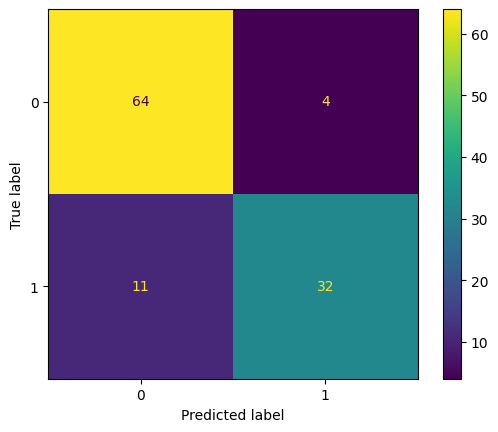

In [85]:
threshold = sklearn.metrics.confusion_matrix(yt_test, y_pred_threshold)
t_plot = sklearn.metrics.ConfusionMatrixDisplay(threshold)
t_plot.plot()

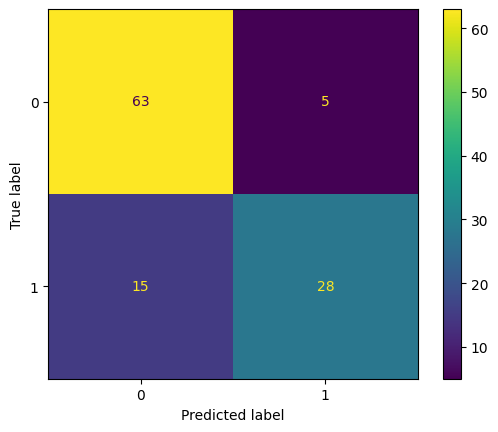

In [86]:
nonthreshold = sklearn.metrics.confusion_matrix(y_test, y_pred_nonthreshold)
nt_plot = sklearn.metrics.ConfusionMatrixDisplay(nonthreshold)
nt_plot.plot()